##Prediction of boiling points of alkanes.

#### Reference : 
*D. Cherqaoui and D. Villemin. Use of neural network to determine the boiling point of alkanes. J. Chem. Soc. Faraday Trans., 1994. 90(1):97-102*

In this quick tutorial we are going to build a linear regression model for predicting of boiling points of alkanes. The training and the testing datasets are publically available and can be found [here](http://ftp.ics.uci.edu/pub/baldig/learning/alkanes/).

###  Feature extraction using [RDKIT](http://www.rdkit.org/)

In [ ]:
import time, csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors


def get_smiles_bp(file_name):
    '''
    Return smile strings and boiling points(bp).
    '''    
    with open(file_name, 'r') as f:
        csv_reader = csv.reader(f)
        data = [row for row in csv_reader]
        smiles = [line[0].split()[0] for line in data]
        bp = [float(line[0].split()[1]) for line in data]
        return zip(smiles, bp)
    

def extract_descr(data):
    '''
    Return a list of descriptors for each smile string
    '''  
    list_of_descr = []
    for mol in data:         
        m = Chem.MolFromSmiles(mol[0])
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        each_mol = [i for i in calc.CalcDescriptors(m)]  
        each_mol.append(mol[0])
        each_mol.append(mol[1])
        list_of_descr.append(each_mol)
    
    return list_of_descr
 
# Getting descriptors names
descr_names = [i[0] for i in Descriptors._descList]

train_data = extract_descr(get_smiles_bp('a2_tr.txt'))
test_data = extract_descr(get_smiles_bp('a2_ts.txt'))

# Appending 'smiles' and 'bp' to the descriptors names
descr_names.append('smiles')
descr_names.append('bp')

In [ ]:
# Writing data to .csv files
def write_to_csv(file_name, data):
    with open(file_name, 'wb') as f:
        csv_writer = csv.writer(f, delimiter = ',')
        csv_writer.writerow(descr_names)
        csv_writer.writerows(data)
        
write_to_csv('rdkit_descr_train.csv', train_data)
write_to_csv('rdkit_descr_test.csv', test_data)

Files with descriptors can be downloaded from here: [rdkit_descr_train.csv](https://www.dropbox.com/s/2zh90w0p2kydnr4/rdkit_descr_train.csv?dl=0), [rdkit_descr_test.csv](https://www.dropbox.com/s/w58upj5n7pcdyw2/rdkit_descr_test.csv?dl=0)

### Building the model.

In [1]:
# Importing required libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading data into Pandas data frame

train_data = pd.read_csv('rdkit_descr_train.csv')
test_data = pd.read_csv('rdkit_descr_train.csv')

#Removing ExactMolWt column from the datasets
X_train = train_data[train_data.columns[:-2]].drop('ExactMolWt', axis=1)
y_train = train_data.bp

X_test = test_data[test_data.columns[:-2]].drop('ExactMolWt', axis=1)
y_test = test_data.bp 

In [ ]:
# You can get a summary statistics of a data frame using describe() method
# Exapmle: X_train.describe()

In [3]:
# Importing a linear model and r2_score
from sklearn import linear_model
from sklearn.metrics import r2_score

model = linear_model.LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Getting a list of predicted boiling points(y_pred)
y_pred = model.predict(X_test)

# Getting the r2 score (performance) of our model
score = r2_score(y_test, y_pred)

print 'R2 = {}'.format(round(score, 4))

R2 = 0.9958


In [4]:
# Saving the model using pickle module

import pickle

lin_reg = pickle.dumps(model)

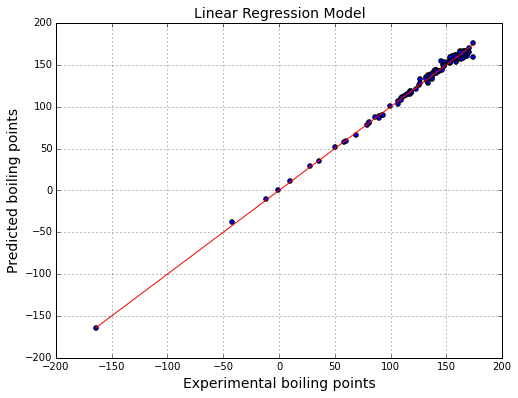

In [5]:
# Setting a figure size
plt.rcParams['figure.figsize'] = (8.0, 6.0)

# Plotting the results. Due to a huge ovelap, experimental boiling points are drawn as a line

plt.plot(y_test, y_test, color = 'r', )
plt.scatter(y_test, y_pred)
plt.grid(1)
plt.title('Linear Regression Model', fontsize = 14)
plt.xlabel('Experimental boiling points', fontsize = 14)
plt.ylabel('Predicted boiling points', fontsize = 14)

In [6]:
# Building a very simple user interface

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

class PredictBP(object):
    '''
    Provide a user interface for predicting boiling points of alkanes.
    Input -> smiles string, Output -> boiling point
    '''
    def __init__(self, smiles):
        self.smiles = smiles
                
    def predict(self):
        descr_names = [i[0] for i in Descriptors._descList if i[0] != 'ExactMolWt']
        m = Chem.MolFromSmiles(self.smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        descr = [i for i in calc.CalcDescriptors(m)]  
        self.model = pickle.loads(lin_reg)
        self.pred_bp = self.model.predict(descr)
        print 'Predicted boiling point is: {:.2f} C'.format(self.pred_bp[0])        
    

In [7]:
# Enter your smile string
bp = PredictBP('CCCCC(C)C(C)C') 
bp.predict()

Predicted boiling point is: 139.67 C
